# Tabu search
Algorytm tabu sam w sobie nie jest algorytmem, a przepisem jak taki algorytm
przygotować w zależności od przedstawionego problemu. Składa się on z 5 podstawowych kroków

## Tworzenie algorytmu

### 1. Inicjalizacja rozwiązania początkowego ###

Jest to rozwiązanie od którego zaczniemy poszukiwanie naszego rozwiązania minimalnego. W naszym przypadku robimy
to na 4 sposoby

```{python}
def initialize_shedule(times, method="random"):
    if method == "neh":
        return NEHmodifications.neh_ext4(times)[0]
    if method == "johnson":
        return Johnson.multi_machines_Johnson(times)
    if method == "random":
        tmp = list(range(1, len(times)+1))
        random.shuffle(tmp)
        return tmp
    if method == "sequence":
        return list(range(1, len(times)+1))
```

Jak widzimy jako pierwsze rozwiązanie możemy przyjąć wynik działania innego algorytmu (neh lub Johnsona),
sekwencje 1,2,3,4..., albo zupełnie losową kolejność

### 2. Geneowanie sąsiedztwa ###

Zastosowaliśmy trzy sposoby generowania sąsiedztw: swap, inverse i insert. Do funkcji inverse dodaliśmy
również opcje zmiany długości fragmentu listy która będzie odwracana.

```{python}
def neighbourhoods_generator(schedule, function="swap", inverse_len=4):
    neighbourhoods_list = []
    functions = function.split(",")
    if "swap" in functions:
        neighbourhoods_list.extend(swap_neighbourhoods(schedule, neighbourhoods=neighbourhoods_list[:]))

    if "insert" in functions:
        neighbourhoods_list.extend(insert_neighbourhoods(schedule, neighbourhoods=neighbourhoods_list[:]))

    if "inverse" in functions:
        neighbourhoods_list.extend(inverse_neighbourhoods(schedule, neighbourhoods=neighbourhoods_list[:], inverse_len=inverse_len))
    return neighbourhoods_list
```

Jak widzimy funkcja jest przystosowana do użycia więcej niż jednego spsobu na generowania sąsiedztw

Sama przykłądowa funkcja wygląda następująco (w tym wypadku funkcja swap)
```{python}
def swap_neighbourhoods(schedule, neighbourhoods):
    for i in range(0, len(schedule)):
        temp_schedule = schedule[:]
        for j in range(i + 1, len(schedule)):
            temp_schedule[i], temp_schedule[j] = temp_schedule[j], temp_schedule[i]
            if temp_schedule not in neighbourhoods:
                neighbourhoods.append(temp_schedule[:])
            temp_schedule[i], temp_schedule[j] = temp_schedule[j], temp_schedule[i]
    return neighbourhoods
```

### 3. Wybranie najlepszego sąsiada ###
Teraz z naszej listy sąsiedztw musimy wybrać element który najlepiej sepłnia naszą funkcje celu
(w tym wypadku dążymy do jak najmniejszego Cmax. W razie nie wystąpienia zadowalającego nas Cmax
dodaliśmy opcje powrotu do elementów z listy Tabu.

```{python}
def best_neighbourhood(schedules, times, tabu, current):
    cmin = Cmax.count_cmax(current, list((map(list, zip(*times)))))
    change = False
    tmp = schedules[0]
    for schedule in schedules:
        if schedule not in tabu:
            cmax = Cmax.count_cmax(schedule, list((map(list, zip(*times)))))
            if cmax < cmin:
                cmin = cmax
                tmp = schedule
                change = True
    if not change:
        for schedule in tabu:
            cmax = Cmax.count_cmax(schedule, list((map(list, zip(*times)))))
            if cmax < cmin:
                cmin = cmax
                tmp = schedule

    return cmin, tmp
```
Dodaliśmy również mechanizm sprawdzający czy dany element już nie został uwzględniony w innej funkcji
w liście sąsiedztw
### 4. Lista tabu ###
Nie zdefiniowaliśmy twardo maksymalnej wielkości listy tabu. Uznaliśmy to za element które należy poddać badaniom.
Zastosowaliśmy tu jednak podejście przetrzymywania wszystkich wartości jakie odwiedziliśmy, i uznajemy tyle ile
początkowo założyliśmy jako maksymalną wartość. Początkowo pozwoliło to nam na zmienianie maksymalnego rozmiaru tabu
listy w czasie działania programu jednka uznaliśmy że to nie sprawdza się 

### 5. Kryterium stopu ###

Zastosowaliśmy 4 kryteria stopu:
- Ograniczenie czzasowe -  Co każdą iteracje sprawdzamy czy nie przekroczyliśmy pewnego zadanego
przez nas wcześniej czasu
- Ograniczenie iteracyjne - Wykonujemy określoną ilość iteracji
- Ograniczenie braku poprawy Cmax - Przerwamy po określonej ilości iteracji bez poprawy naszego Cmax
- Nigdy nie zatrzymujemy - Musimy ręcznie wymusić zatrzymanie (nie jest to co prawda zbyt dobra praktyka
i wolelibyśmy żeby program się zakończył w bardziej naturalny sposób). Program co każdą iteracje zapisuje
nam wynik do pliku dzięki czemu mamy do niego później dostęp.

Dodatkowo z racji że algorytm może wpaść w minimum z którego nie wyjdzie i pracować,
dodaliśmy opcje zresetowania wraz z zapamiętaniem dotychczsowego najlepszego wyniku
(obecnie tylko przy kryterium stop i time)

## Optymalizacja ##
Jak widzimy algorytm jest dosyć otwarty i jest wiele rzeczy do ustawienia w zależności od
problemu z jakim przyjdzie nam się mierzyć, mimo że nie zaimplementowaliśmy wszystkich jego możliwości
(na przykład spokojnie można dodać ograniczenia co do ilości sąsiadów).
#### Wybór sąsiada ####
W pierwszej kolejności zainicjuje przykładowe rozwiązanie o różnych długościach i zbadamy czas
jaki każda z nich potrzebuje żeby wygenerowani zostali jej sąsiedzi

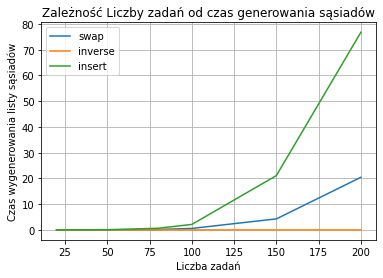

In [1]:
import TS
from time import perf_counter
from matplotlib import pyplot as plt
leng = [20, 50, 80, 100, 150, 200]
functions = ["swap", "inverse", "insert"]
schedules = [list(range(1, x+1)) for x in leng]
y = [len(x) for x in schedules]
times = {k: [] for k in functions}
for function in functions:
    for schedule in schedules:
        start = perf_counter()
        TS.neighbourhoods_generator(schedule, function=function)
        times[function].append(perf_counter()-start)
    plt.plot(leng, times[function], label=function)
plt.legend()
plt.grid()
plt.title("Zależność Liczby zadań od czas generowania sąsiadów")
plt.xlabel("Liczba zadań")
plt.ylabel("Czas wygenerowania listy sąsiadów")
plt.show()

Jak widać czasy wygenerowania listy sąsiadów potrafią znacząco się różnić sprawdźmy na przykładowych danych
zwaierających 100 zadań, jak wygląda efektywność znajdowania najlepszego Cmax. Jako inicjujące rozwiązanie
przyjmiemy sobie sequence. Dzięki temu wszędzie zaczniemy od jednakowego rozwiązania które niepowinno być
bliskie poprawnemu

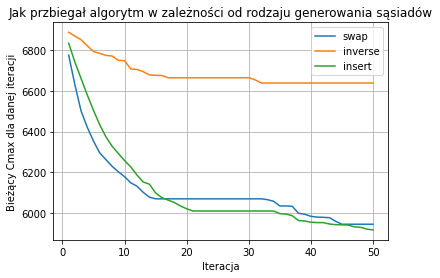

In [2]:
import Load
data = Load.read_datest("Data/data.txt")[80]
init = "sequence"
stop_func = "iter"
iter_n = 50
history = {k: [] for k in functions}
iterations = list(range(1, iter_n+1))
for function in functions:
    history[function] = TS.Tabu_search(data, stop=stop_func, init_function=init,
                                   iter=iter_n, neighbourhoods_function=str(function))[2]
    plt.plot(iterations, history[function], label=function)

plt.legend()
plt.grid()
plt.title("Jak przbiegał algorytm w zależności od rodzaju generowania sąsiadów")
plt.xlabel("Iteracja")
plt.ylabel("Bieżący Cmax dla danej iteracji")
plt.show()

Jak widzimy znajdowanie sąsiadów po przez inverse jest bardzo nieefektywne w tym przypadku i mimo że jest to
najszybszyalgorytm szukania sąsiadów to nie opłaca się rozwiązywać naszego problemu tylko przy jego pomocy.
Jest to spowodowane tym że generuje on małą ilość sąsiadów i na dobrą sprawę dla parametru inverse_len=3
wygenerowani przez niego sąsiedzi zawierają się już w funkcji swap.
Zdecydowanie lepiej żeby służył on jako pomocniczy. Jako dodatkowe zastosowanie tego algorytmu można
wykorzystać wygenerowanie przy jego pomocy znacznie bardziej odległych sąsiadów
```{python}
def global_neighbourhoods(current, zones, zone_scale):
    tmp = []
    tmp_neigh = neighbourhoods_generator(current, function="inverse",
                                                  inverse_len=len(current)-zones)
    for neigh in tmp_neigh:
        print(neigh)
        tmp.extend(neighbourhoods_generator(neigh, function="inverse",
                                                    inverse_len=len(current)-zone_scale)
```

Jest to rozwiązanie którego ostatecznie w żaden sposób nie użyliśmy przy implementacji algorytmu i nie wiemy na ile
faktycznie można je wykorzystać. Założenie jest takie że generujemy pewną ilość sąsiadów (zones), z czego im jest ich
więcej tym bardziej są odlegliod pierowtnego sąsiada, a następnie na podstawie odpowiednio dobranej funkcji zones_scale
dla każdego wcześniej wygenerowanego sąsiada, generujemy dodatkowych sąsiadów. Dzięki temu możemy przejrzeć czy któryś
z bardziej odległych obszarów ma potencjał do bycia lepszym niż obecny


Przeprowadźmy jednak ten test dla problemu zawierającego mniejszą ilość zadań

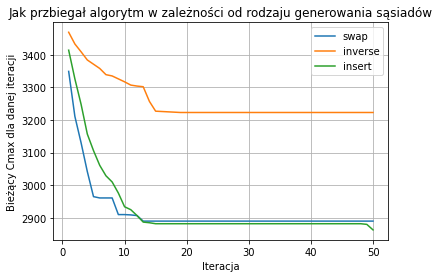

In [3]:
data = Load.read_datest("Data/data.txt")[32]
history = {k: [] for k in functions}
iterations = list(range(1, iter_n+1))
for function in functions:
    history[function] = TS.Tabu_search(data, stop=stop_func, init_function=init,
                                   iter=iter_n, neighbourhoods_function=str(function))[2]
    plt.plot(iterations, history[function], label=function)

plt.legend()
plt.grid()
plt.title("Jak przbiegał algorytm w zależności od rodzaju generowania sąsiadów")
plt.xlabel("Iteracja")
plt.ylabel("Bieżący Cmax dla danej iteracji")
plt.show()

Jak widać nawet dla mniej złożonych problemów wciąż widać przewage funkcji swap i insert.
Sprawdźmy jednak jak będą wyglądać różnice gdy połączymy ze sobą funkcje swap i insert ze sobą
(jak wcześniej wspomniałem inverse mało zmieni gdyż jego wyniki zawierają się w funkcji swap).
Test przeprowadzamy dla problemu 100 zadań

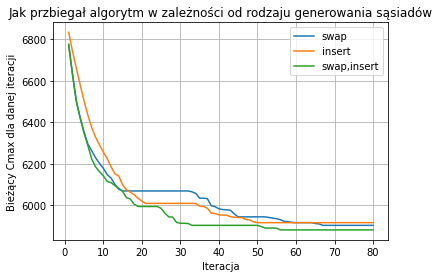

In [4]:
data = Load.read_datest("Data/data.txt")[80]
functions=["swap", "insert", "swap,insert"]
history = {k: [] for k in functions}
iter_n = 80
iterations = list(range(1, iter_n+1))
for function in functions:
    history[function] = TS.Tabu_search(data, stop=stop_func, init_function=init,
                                   iter=iter_n, neighbourhoods_function=str(function))[2]
    plt.plot(iterations, history[function], label=function)

plt.legend()
plt.grid()
plt.title("Jak przbiegał algorytm w zależności od rodzaju generowania sąsiadów")
plt.xlabel("Iteracja")
plt.ylabel("Bieżący Cmax dla danej iteracji")
plt.show()

Jak widzimy mimo że połączenie swap i insert mimo że na początku zaczęło najlepiej dążyć do minimum,
to algorytm utknął w minimum lokalnym z którego nie mógł wyjść, zaś przy oddzielnym wykorzystaniu
swap i insert algorytm po dłuższym czasie osiągnął lepszy wynik niż przy połączeniu tych dwóch.
Nie jesteśmy przekonani czy tak powinno być jednak z wyników tych badań można stwierdzić że algorytm też
nie powinien generować bardzo dużej ilości bliskich sąsiadów

### Lista tabu ###
Mimo że nasz alogorytm posiada funkcje która pomniejsza listę tabu w przypadku gdy algorytm nie znajduje
sąsiada o mniejszym Cmax to sprawdźmy jak na efektywność wpłyną różne długości maksymalnej listy tabu.
Badanie wykonujemy dla problemu 100 zadań

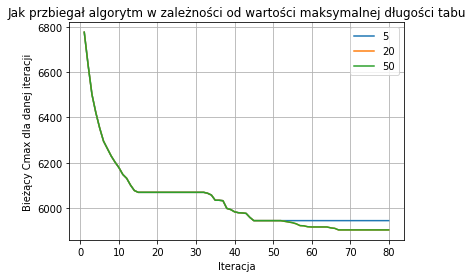

In [5]:
tabus=[5, 20, 50]
history = {k: [] for k in tabus}
iter_n = 80
iterations = list(range(1, iter_n+1))
for tabu in tabus:
    history[tabu] = TS.Tabu_search(data, stop=stop_func, init_function=init,
                                   iter=iter_n, neighbourhoods_function='swap', max_tabu=tabu)[2]
    plt.plot(iterations, history[tabu], label=str(tabu))

plt.legend()
plt.grid()
plt.title("Jak przbiegał algorytm w zależności od wartości maksymalnej długości tabu")
plt.xlabel("Iteracja")
plt.ylabel("Bieżący Cmax dla danej iteracji")
plt.show()

Tu powinny być wnioski ale szczerze powiedziawszy nie wiem czy to wyżej powinno tak wyglądać

### Rozwiązanie początkowe ###
Zbadajmy wpływ rozwiązania początkowego na przebieg algorytmu. Celowo nie badam random gdyż jak nazwa
wskazuje potrafi być zbyt losowe. Zamiast tego zastosuje sequence

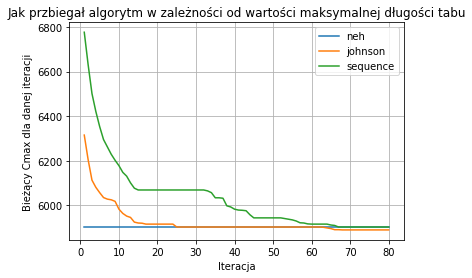

In [6]:
inits = ["neh", "johnson", "sequence"]
history = {k: [] for k in inits}
iter_n = 80
iterations = list(range(1, iter_n+1))
for init in inits:
    history[init] = TS.Tabu_search(data, stop=stop_func, init_function=init,
                                   iter=iter_n, neighbourhoods_function='swap')[2]
    plt.plot(iterations, history[init], label=str(init))

plt.legend()
plt.grid()
plt.title("Jak przbiegał algorytm w zależności od wartości maksymalnej długości tabu")
plt.xlabel("Iteracja")
plt.ylabel("Bieżący Cmax dla danej iteracji")
plt.show()

Jak widzimy niezależnie od tego jak zaczniemy szukać rozwiązania, wszytkie one dążą do podobnego wyniku,
który znajduje się w okolicy rozwiązania neh

### Kryterium stopu i porównanie z innymi algorytmami ###
Puśćmy na zakończenie nasz algorytm na dłuższy czas żeby móc między innymi zaobserwować funkcje resetu.
Przy okazji możemy porównać rozwiązanie z wynikami innych algorytmów

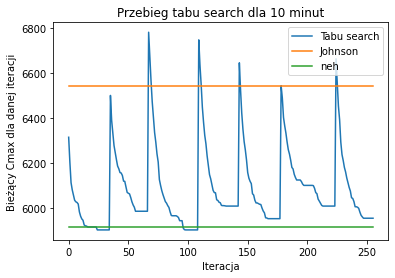

Tabu:  5903
NEH:  5918
Johnson:  6544


In [7]:
from neh import NEH, Cmax
import Johnson

data = Load.read_datest("Data/data.txt")[80]
neh_cmax = NEH.neh(data)[1]
john_cmax = Cmax.count_cmax(Johnson.multi_machines_Johnson(list((map(list, zip(*data))))), data)
_, cmax, history = TS.Tabu_search(data, stop="times", stop_time=10*60)
y = list(range(len(history)))

plt.plot(y, history, label="Tabu search")
plt.plot(y, [john_cmax for _ in y], label="Johnson")
plt.plot(y, [neh_cmax for _ in y], label="neh")
plt.legend()
plt.title("Przebieg tabu search dla 10 minut")
plt.xlabel("Iteracja")
plt.ylabel("Bieżący Cmax dla danej iteracji")
plt.show()

print(f"Tabu:  {min(history)}")
print(f"NEH:  {neh_cmax}")
print(f"Johnson:  {john_cmax}")

Jak widać program przy odpowiedniu długim przeszukiwaniu był w stanie zejść poniżej wartości cmax wyliczonej przez algorytm NEH.
Na wykresie również dobrze widać działanie resetówkiedy funkcja za długo była w jednym miejscu